# Retail Security Object Detection with YOLOv8s

## I have a requirements file that downloads the necessary packages including ultralytics to import the YOLO model

In [ ]:
!pip install -r requirements.txt

### Importing all the necessary packages 

In [1]:
import os
import cv2
import numpy as np
from ultralytics import YOLO
import yaml
from collections import Counter

### Checking to make sure video files exists.(They are the same video files from the folder provided in the doc)

In [2]:
video_files = [f for f in os.listdir('.') if f.endswith(('.mp4', '.mov'))]
print(f"Found {len(video_files)} videos")
for v in video_files:
    print(f"  {v}")

Found 2 videos
  1720884888.mov
  2024-07-12_17-05-13_17-13-01.mp4


## In this I am extracting the frames from both the videos, the mov video file has 204 frames extracted and the mp4 video file has 2455 frames extracted

In [4]:
os.makedirs('frames', exist_ok=True)

video1 = '2024-07-12_17-05-13_17-13-01.mp4'
cap = cv2.VideoCapture(video1)
count = 0
while True:
    ret, frame = cap.read()
    if not ret:
        break
    cv2.imwrite(f'frames/mp4_frame_{count:04d}.jpg', frame)
    count += 1
cap.release()
print(f"Extracted {count} frames from mp4")

video2 = '1720884888.mov'
cap = cv2.VideoCapture(video2)
count = 0
while True:
    ret, frame = cap.read()
    if not ret:
        break
    cv2.imwrite(f'frames/mov_frame_{count:04d}.jpg', frame)
    count += 1
cap.release()
print(f"Extracted {count} frames from mov")

Extracted 2455 frames from mp4
Extracted 204 frames from mov


### Load Dataset from Roboflow
The frames were labeled using Grounding DINO for initial detection followed by manual refinement in Roboflow. Screenshots of roboflow manual labeling will be pasted. I mainly imported the majority of the extracted frames into roboflow and labelled the ones DINO missed

In [3]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="pw8zaVqSSrWlDkit4qON")
project = rf.workspace("yoloobject-detection-30dil").project("yolo-object-detection-2sxly")
version = project.version(1)
dataset = version.download("yolov12")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to YOLO-Object-Detection-1 in yolov12:: 100%|████████████████████████████████| 1562/1562 [00:00<00:00, 1823.74it/s]


In [4]:
dataset_path = 'YOLO-Object-Detection-1'

with open(f'{dataset_path}/data.yaml', 'r') as f:
    data = yaml.safe_load(f)
    print(data)

{'train': '../train/images', 'val': '../valid/images', 'test': '../test/images', 'nc': 10, 'names': ['0', '1', '2', '3', 'Person', 'backpack', 'bottle', 'chips', 'product', 'refrigerator'], 'roboflow': {'workspace': 'yoloobject-detection-30dil', 'project': 'yolo-object-detection-2sxly', 'version': 1, 'license': 'CC BY 4.0', 'url': 'https://universe.roboflow.com/yoloobject-detection-30dil/yolo-object-detection-2sxly/dataset/1'}}


In [5]:
for split in ['train', 'valid', 'test']:
    img_dir = f'{dataset_path}/{split}/images'
    lbl_dir = f'{dataset_path}/{split}/labels'
    
    num_images = len([f for f in os.listdir(img_dir) if f.endswith('.jpg')])
    num_labels = len([f for f in os.listdir(lbl_dir) if f.endswith('.txt')])
    
    print(f"{split}: {num_images} images, {num_labels} labels")

train: 682 images, 682 labels
valid: 31 images, 31 labels
test: 62 images, 62 labels


### Analyzing Initial Class Distribution after roboflow labelling

In [6]:
all_classes = Counter()

for split in ['train', 'valid', 'test']:
    label_dir = f'{dataset_path}/{split}/labels'
    
    for label_file in os.listdir(label_dir):
        if label_file.endswith('.txt'):
            with open(f'{label_dir}/{label_file}', 'r') as f:
                for line in f:
                    if line.strip():
                        class_id = int(line.split()[0])
                        all_classes[class_id] += 1

print("Class distribution:")
for class_id in sorted(all_classes.keys()):
    print(f"  Class {class_id}: {all_classes[class_id]} instances")

Class distribution:
  Class 0: 1639 instances
  Class 1: 153 instances
  Class 2: 2 instances
  Class 3: 1067 instances
  Class 4: 1 instances
  Class 5: 1 instances
  Class 6: 145 instances
  Class 7: 2 instances
  Class 8: 7 instances
  Class 9: 1 instances


### Remap Class IDs
Roboflow exported with inconsistent class IDs. Instead of manually changing on the tool I remapped to standard 0-3 format.

In [7]:
id_map = {0: 0, 1: 1, 6: 2, 3: 3}

for split in ['train', 'valid', 'test']:
    label_dir = f'{dataset_path}/{split}/labels'
    
    for label_file in os.listdir(label_dir):
        if not label_file.endswith('.txt'):
            continue
        
        filepath = f'{label_dir}/{label_file}'
        new_lines = []
        
        with open(filepath, 'r') as f:
            for line in f:
                if line.strip():
                    parts = line.split()
                    old_id = int(parts[0])
                    
                    if old_id in id_map:
                        parts[0] = str(id_map[old_id])
                        new_lines.append(' '.join(parts) + '\n')
        
        with open(filepath, 'w') as f:
            f.writelines(new_lines)

print("Remapping complete")

Remapping complete


### Here I am just seeing how many instances are available for each of the labelled classes

In [8]:
remapped_classes = Counter()

for split in ['train', 'valid', 'test']:
    label_dir = f'{dataset_path}/{split}/labels'
    
    for label_file in os.listdir(label_dir):
        if label_file.endswith('.txt'):
            with open(f'{label_dir}/{label_file}', 'r') as f:
                for line in f:
                    if line.strip():
                        class_id = int(line.split()[0])
                        remapped_classes[class_id] += 1

class_names = ['person', 'backpack', 'bottle', 'refrigerator']

print("Remapped class distribution:")
for class_id in sorted(remapped_classes.keys()):
    print(f"  {class_id} ({class_names[class_id]}): {remapped_classes[class_id]} instances")

Remapped class distribution:
  0 (person): 1639 instances
  1 (backpack): 153 instances
  2 (bottle): 145 instances
  3 (refrigerator): 1067 instances


### Updated data Configuration File

In [9]:
data_yaml = {
    'path': os.path.abspath(dataset_path),
    'train': 'train/images',
    'val': 'valid/images',
    'test': 'test/images',
    'names': ['person', 'backpack', 'bottle', 'refrigerator'],
    'nc': 4
}

with open(f'{dataset_path}/data.yaml', 'w') as f:
    yaml.dump(data_yaml, f, default_flow_style=False, sort_keys=False)

print("Updated data.yaml")

Updated data.yaml


### After viewing the videos myself and seeing the results of DINO I realized that the smalled objects like the bottle when the person was holding it in hand was not being captured and the number of instances were low, so after verifying the instances I did data augemntation

In [10]:
import random

bottle_images = []
label_dir = f'{dataset_path}/train/labels'
img_dir = f'{dataset_path}/train/images'

for label_file in os.listdir(label_dir):
    if not label_file.endswith('.txt'):
        continue
    
    with open(f'{label_dir}/{label_file}', 'r') as f:
        for line in f:
            if line.strip() and int(line.split()[0]) == 2:
                img_file = label_file.replace('.txt', '.jpg')
                bottle_images.append({
                    'img': f'{img_dir}/{img_file}',
                    'lbl': f'{label_dir}/{label_file}'
                })
                break

print(f"Found {len(bottle_images)} images with bottles")
print(f"Current bottle instances: 145")

Found 118 images with bottles
Current bottle instances: 145


In [14]:
def augment_image(img_path, lbl_path, aug_id):
    img = cv2.imread(img_path)
    if img is None:
        return None, None
    
    with open(lbl_path, 'r') as f:
        labels = [line.strip().split() for line in f if line.strip()]
    
    aug_type = aug_id % 8
    
    if aug_type == 0:
        img = cv2.flip(img, 1)
        new_labels = []
        for label in labels:
            class_id, x, y, w, h = label
            x = str(1.0 - float(x))
            new_labels.append([class_id, x, y, w, h])
        labels = new_labels
    elif aug_type == 1:
        img = np.clip(img * random.uniform(0.6, 1.4), 0, 255).astype(np.uint8)
    elif aug_type == 2:
        mean = img.mean()
        img = np.clip((img - mean) * random.uniform(0.7, 1.5) + mean, 0, 255).astype(np.uint8)
    elif aug_type == 3:
        hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV).astype(np.float32)
        hsv[:, :, 1] *= random.uniform(0.5, 1.5)
        hsv = np.clip(hsv, [0, 0, 0], [179, 255, 255])
        img = cv2.cvtColor(hsv.astype(np.uint8), cv2.COLOR_HSV2BGR)
    elif aug_type == 4:
        hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV).astype(np.float32)
        hsv[:, :, 0] += random.uniform(-15, 15)
        hsv = np.clip(hsv, [0, 0, 0], [179, 255, 255])
        img = cv2.cvtColor(hsv.astype(np.uint8), cv2.COLOR_HSV2BGR)
    elif aug_type == 5:
        img = cv2.GaussianBlur(img, (5, 5), 0)
    elif aug_type == 6:
        noise = np.random.normal(0, 15, img.shape)
        img = np.clip(img + noise, 0, 255).astype(np.uint8)
    elif aug_type == 7:
        img = np.clip(img * random.uniform(0.7, 1.3), 0, 255).astype(np.uint8)
        hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV).astype(np.float32)
        hsv[:, :, 1] *= random.uniform(0.7, 1.3)
        hsv = np.clip(hsv, [0, 0, 0], [179, 255, 255])
        img = cv2.cvtColor(hsv.astype(np.uint8), cv2.COLOR_HSV2BGR)
    
    return img, labels

augs_per_image = 13
count = 0

for bottle_img in bottle_images:
    for i in range(augs_per_image):
        aug_img, aug_labels = augment_image(bottle_img['img'], bottle_img['lbl'], i)
        
        if aug_img is None:
            continue
        
        base = os.path.basename(bottle_img['img']).replace('.jpg', '')
        aug_img_path = f"{img_dir}/{base}_augv2_{i}.jpg"
        aug_lbl_path = f"{label_dir}/{base}_augv2_{i}.txt"
        
        cv2.imwrite(aug_img_path, aug_img)
        
        with open(aug_lbl_path, 'w') as f:
            for label in aug_labels:
                f.write(' '.join(label) + '\n')
        
        count += 1

print(f"Created {count} augmented images")

Created 1534 augmented images


### ### Applied Augmentation Techniques
Used techniques like flip, brightness, contrast, HSV adjustments, blur, and noise to create diverse examples.

In [15]:
final_counts = Counter()

for label_file in os.listdir(label_dir):
    if label_file.endswith('.txt'):
        with open(f'{label_dir}/{label_file}', 'r') as f:
            for line in f:
                if line.strip():
                    final_counts[int(line.split()[0])] += 1

class_names = ['person', 'backpack', 'bottle', 'refrigerator']
total = sum(final_counts.values())

print("Final dataset:")
for class_id in sorted(final_counts.keys()):
    pct = final_counts[class_id] / total * 100
    print(f"  {class_names[class_id]}: {final_counts[class_id]} ({pct:.1f}%)")
print(f"\nTotal: {total} instances")

Final dataset:
  person: 6473 (47.1%)
  backpack: 514 (3.7%)
  bottle: 2688 (19.5%)
  refrigerator: 4077 (29.6%)

Total: 13752 instances


### Now we train the model.

Roboflow already split the dataset into train, test and val so as a first experiment we train the model on that split 

In [16]:
model = YOLO('yolov8s.pt')

results = model.train(
    data=f'{dataset_path}/data.yaml',
    epochs=100,
    imgsz=640,
    batch=16,
    name='retail_yolov8s_final',
    patience=15,
    mosaic=1.0,
    copy_paste=0.5,
    device=0
)

print("Training complete")

Ultralytics 8.3.223 🚀 Python-3.11.14 torch-2.9.0+cu128 CUDA:0 (Tesla V100-SXM2-32GB, 32501MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.5, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=YOLO-Object-Detection-1/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=retail_yolov8s_final, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=15, perspe

This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 932.9±716.1 MB/s, size: 125.2 KB)
val: Scanning /scratch/ppp231/rak/YOLO-Object-Detection-1/valid/labels.cache... 31 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 31/31 24.5Kit/s 0.0s


This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.


Plotting labels to /scratch/ppp231/rak/runs/detect/retail_yolov8s_final/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00125, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /scratch/ppp231/rak/runs/detect/retail_yolov8s_final
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      1/100      4.03G     0.7715      1.007      1.002         10        640: 100% ━━━━━━━━━━━━ 191/191 2.6it/s 1:130.4sss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 1/1 4.6it/s 0.2s
                   all         31        121       0.76      0.542      0.547      0.425

      Epoch    GPU_mem   box_loss   cls_loss   df

### After viewing the results the mAP score we can see that the results arent great and this is mainly due to the lack of examples in the validation set.

So as a next experiment, I will be combining the dataset to have all the labelled dataset as one and train on that

In [18]:
combined_dir = 'YOLO-Combined'
os.makedirs(f'{combined_dir}/images', exist_ok=True)
os.makedirs(f'{combined_dir}/labels', exist_ok=True)

for split in ['train', 'valid', 'test']:
    img_src = f'{dataset_path}/{split}/images'
    lbl_src = f'{dataset_path}/{split}/labels'
    
    for img_file in os.listdir(img_src):
        if img_file.endswith('.jpg'):
            src = f'{img_src}/{img_file}'
            dst = f'{combined_dir}/images/{img_file}'
            os.system(f'cp {src} {dst}')
    
    for lbl_file in os.listdir(lbl_src):
        if lbl_file.endswith('.txt'):
            src = f'{lbl_src}/{lbl_file}'
            dst = f'{combined_dir}/labels/{lbl_file}'
            os.system(f'cp {src} {dst}')

print("Combined all splits")

Combined all splits


In [19]:
combined_yaml = {
    'path': os.path.abspath(combined_dir),
    'train': 'images',
    'val': 'images',
    'names': class_names,
    'nc': 4
}

with open(f'{combined_dir}/data.yaml', 'w') as f:
    yaml.dump(combined_yaml, f, default_flow_style=False)

print("Combined dataset ready")

Combined dataset ready


In [ ]:
model = YOLO('yolov8s.pt')

results = model.train(
    data=f'{combined_dir}/data.yaml',
    epochs=100,
    imgsz=640,
    batch=16,
    name='retail_yolov8s_combined',
    patience=15,
    mosaic=1.0,
    copy_paste=0.5,
    device=0
)

print("Training on combined dataset complete")

Ultralytics 8.3.223 🚀 Python-3.11.14 torch-2.9.0+cu128 CUDA:0 (Tesla V100-SXM2-32GB, 32501MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.5, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=YOLO-Combined/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=retail_yolov8s_combined, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=15, perspective=0

This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1243.8±957.6 MB/s, size: 233.9 KB)
val: Scanning /scratch/ppp231/rak/YOLO-Combined/labels.cache... 3135 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 3135/3135 2.0Mit/s 0.0s0s


This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.


Plotting labels to /scratch/ppp231/rak/runs/detect/retail_yolov8s_combined/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00125, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /scratch/ppp231/rak/runs/detect/retail_yolov8s_combined
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      1/100      4.02G     0.7724      1.007      1.004        114        640: 100% ━━━━━━━━━━━━ 196/196 2.5it/s 1:170.4sss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 98/98 3.0it/s 33.2s0.3ss
                   all       3135      14124      0.679      0.671        0.7      0.528

      Epoch    GPU_mem   box_loss  

### Here we can see how much the scores have improved and this indicates that we should be able to detect the labelled items clearly in most of the cases.

In [6]:
model_combined = YOLO('runs/detect/retail_yolov8s_combined/weights/best.pt')
metrics = model_combined.val()

print(f"\nCombined Model Performance:")
print(f"Overall mAP50-95: {metrics.box.map:.3f}")

Ultralytics 8.3.223 🚀 Python-3.11.14 torch-2.9.0+cu128 CUDA:0 (Tesla V100-SXM2-32GB, 32501MiB)
Model summary (fused): 72 layers, 11,127,132 parameters, 0 gradients, 28.4 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 570.8±65.1 MB/s, size: 243.0 KB)
val: Scanning /scratch/ppp231/rak/YOLO-Combined/labels.cache... 3135 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 3135/3135 2.3Mit/s 0.0s0s


/scratch/ppp231/conda_envs/myproject/lib/python3.11/site-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 196/196 5.0it/s 39.4s0.2ss
                   all       3135      14124      0.948      0.924       0.96      0.875
                person       3101       6679      0.984      0.985      0.994      0.975
              backpack        529        533       0.85      0.789      0.879      0.707
                bottle       2495       2705      0.985      0.927      0.973      0.822
          refrigerator       2884       4207      0.975      0.995      0.994      0.994
Speed: 1.6ms preprocess, 3.5ms inference, 0.0ms loss, 1.0ms postprocess per image
Results saved to /scratch/ppp231/rak/runs/detect/val3

Combined Model Performance:
Overall mAP50-95: 0.875


### Now I'm running the inference with the help of the saved checkpoint to see how it performs. Below is the drive link for the inferred video.
## Link - 

In [3]:
model_combined = YOLO('runs/detect/retail_yolov8s_combined/weights/best.pt')

results_mov = model_combined.predict(
    source='1720884888.mov',
    save=True,
    save_txt=True,
    conf=0.25,
    project='inference_outputs',
    name='mov_detections'
)

print("MOV inference complete")


WARNING ⚠️ 
inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

video 1/1 (frame 1/204) /scratch/ppp231/rak/1720884888.mov: 448x640 (no detections), 160.6ms
video 1/1 (frame 2/204) /scratch/ppp231/rak/1720884888.mov: 448x640 2 persons, 2 refrigerators, 5.4ms
video 1/1 (frame 3/204) /scratch/ppp231/rak/1720884888.mov: 448x640 2 persons, 2 refrigerators, 5.4ms
video 1/1 (frame 4/204) /scratch/ppp231/rak/1720884888.mov: 448x640 2 persons, 2 refrigerators, 5.2ms
video 1/1 (frame 5/204) /scratch/ppp231/rak/1720884888.mo

### Here I'm running the inference in batches for the mp4 due to the large volume of frames and the length of the video. After running them in batches I combined them to form the final inferred video. 

## Link - 

In [7]:
batch_dir = 'mp4_batch1'
os.makedirs(batch_dir, exist_ok=True)

cap = cv2.VideoCapture('2024-07-12_17-05-13_17-13-01.mp4')
count = 0

while count < 500:
    ret, frame = cap.read()
    if not ret:
        break
    cv2.imwrite(f'{batch_dir}/frame_{count:05d}.jpg', frame)
    count += 1

cap.release()
print(f"Extracted {count} frames")

results = model_combined.predict(
    source=batch_dir,
    save=True,
    save_txt=True,
    conf=0.25,
    project='inference_outputs',
    name='mp4_batch1'
)

print("Batch 1 complete")

Extracted 500 frames

image 1/500 /scratch/ppp231/rak/mp4_batch1/frame_00000.jpg: 384x640 1 person, 1 bottle, 1 refrigerator, 46.8ms
image 2/500 /scratch/ppp231/rak/mp4_batch1/frame_00001.jpg: 384x640 1 person, 1 bottle, 1 refrigerator, 5.6ms
image 3/500 /scratch/ppp231/rak/mp4_batch1/frame_00002.jpg: 384x640 2 persons, 1 refrigerator, 5.3ms
image 4/500 /scratch/ppp231/rak/mp4_batch1/frame_00003.jpg: 384x640 2 persons, 1 refrigerator, 5.4ms
image 5/500 /scratch/ppp231/rak/mp4_batch1/frame_00004.jpg: 384x640 2 persons, 1 refrigerator, 5.5ms
image 6/500 /scratch/ppp231/rak/mp4_batch1/frame_00005.jpg: 384x640 2 persons, 1 refrigerator, 5.4ms
image 7/500 /scratch/ppp231/rak/mp4_batch1/frame_00006.jpg: 384x640 2 persons, 1 refrigerator, 5.3ms
image 8/500 /scratch/ppp231/rak/mp4_batch1/frame_00007.jpg: 384x640 2 persons, 1 refrigerator, 5.5ms
image 9/500 /scratch/ppp231/rak/mp4_batch1/frame_00008.jpg: 384x640 2 persons, 1 refrigerator, 5.4ms
image 10/500 /scratch/ppp231/rak/mp4_batch1/frame_

In [8]:
batch_dir = 'mp4_batch2'
os.makedirs(batch_dir, exist_ok=True)

cap = cv2.VideoCapture('2024-07-12_17-05-13_17-13-01.mp4')
cap.set(cv2.CAP_PROP_POS_FRAMES, 500)
count = 500

while count < 1000:
    ret, frame = cap.read()
    if not ret:
        break
    cv2.imwrite(f'{batch_dir}/frame_{count:05d}.jpg', frame)
    count += 1

cap.release()
print(f"Extracted frames 500-{count-1}")

results = model_combined.predict(
    source=batch_dir,
    save=True,
    save_txt=True,
    conf=0.25,
    project='inference_outputs',
    name='mp4_batch2'
)

print("Batch 2 complete")

Extracted frames 500-999

image 1/500 /scratch/ppp231/rak/mp4_batch2/frame_00500.jpg: 384x640 4 persons, 1 refrigerator, 5.5ms
image 2/500 /scratch/ppp231/rak/mp4_batch2/frame_00501.jpg: 384x640 3 persons, 2 refrigerators, 5.4ms
image 3/500 /scratch/ppp231/rak/mp4_batch2/frame_00502.jpg: 384x640 3 persons, 1 refrigerator, 5.5ms
image 4/500 /scratch/ppp231/rak/mp4_batch2/frame_00503.jpg: 384x640 3 persons, 1 refrigerator, 5.4ms
image 5/500 /scratch/ppp231/rak/mp4_batch2/frame_00504.jpg: 384x640 3 persons, 1 refrigerator, 5.4ms
image 6/500 /scratch/ppp231/rak/mp4_batch2/frame_00505.jpg: 384x640 3 persons, 1 refrigerator, 5.3ms
image 7/500 /scratch/ppp231/rak/mp4_batch2/frame_00506.jpg: 384x640 3 persons, 1 refrigerator, 5.3ms
image 8/500 /scratch/ppp231/rak/mp4_batch2/frame_00507.jpg: 384x640 3 persons, 1 refrigerator, 5.3ms
image 9/500 /scratch/ppp231/rak/mp4_batch2/frame_00508.jpg: 384x640 3 persons, 1 refrigerator, 5.3ms
image 10/500 /scratch/ppp231/rak/mp4_batch2/frame_00509.jpg: 384

In [9]:
batch_dir = 'mp4_batch3'
os.makedirs(batch_dir, exist_ok=True)

cap = cv2.VideoCapture('2024-07-12_17-05-13_17-13-01.mp4')
cap.set(cv2.CAP_PROP_POS_FRAMES, 1000)
count = 1000

while count < 1500:
    ret, frame = cap.read()
    if not ret:
        break
    cv2.imwrite(f'{batch_dir}/frame_{count:05d}.jpg', frame)
    count += 1

cap.release()
print(f"Extracted frames 1000-{count-1}")

results = model_combined.predict(
    source=batch_dir,
    save=True,
    save_txt=True,
    conf=0.25,
    project='inference_outputs',
    name='mp4_batch3'
)

print("Batch 3 complete")

Extracted frames 1000-1499

image 1/500 /scratch/ppp231/rak/mp4_batch3/frame_01000.jpg: 384x640 2 persons, 2 refrigerators, 5.4ms
image 2/500 /scratch/ppp231/rak/mp4_batch3/frame_01001.jpg: 384x640 2 persons, 2 refrigerators, 5.4ms
image 3/500 /scratch/ppp231/rak/mp4_batch3/frame_01002.jpg: 384x640 2 persons, 2 refrigerators, 5.3ms
image 4/500 /scratch/ppp231/rak/mp4_batch3/frame_01003.jpg: 384x640 2 persons, 2 refrigerators, 5.3ms
image 5/500 /scratch/ppp231/rak/mp4_batch3/frame_01004.jpg: 384x640 2 persons, 1 refrigerator, 5.4ms
image 6/500 /scratch/ppp231/rak/mp4_batch3/frame_01005.jpg: 384x640 2 persons, 1 refrigerator, 5.3ms
image 7/500 /scratch/ppp231/rak/mp4_batch3/frame_01006.jpg: 384x640 2 persons, 1 refrigerator, 5.3ms
image 8/500 /scratch/ppp231/rak/mp4_batch3/frame_01007.jpg: 384x640 2 persons, 1 refrigerator, 5.5ms
image 9/500 /scratch/ppp231/rak/mp4_batch3/frame_01008.jpg: 384x640 2 persons, 1 refrigerator, 5.2ms
image 10/500 /scratch/ppp231/rak/mp4_batch3/frame_01009.jpg

In [10]:
batch_dir = 'mp4_batch4'
os.makedirs(batch_dir, exist_ok=True)

cap = cv2.VideoCapture('2024-07-12_17-05-13_17-13-01.mp4')
cap.set(cv2.CAP_PROP_POS_FRAMES, 1500)
count = 1500

while count < 2000:
    ret, frame = cap.read()
    if not ret:
        break
    cv2.imwrite(f'{batch_dir}/frame_{count:05d}.jpg', frame)
    count += 1

cap.release()
print(f"Extracted frames 1500-{count-1}")

results = model_combined.predict(
    source=batch_dir,
    save=True,
    save_txt=True,
    conf=0.25,
    project='inference_outputs',
    name='mp4_batch4'
)

print("Batch 4 complete")

Extracted frames 1500-1999

image 1/500 /scratch/ppp231/rak/mp4_batch4/frame_01500.jpg: 384x640 2 persons, 2 refrigerators, 5.4ms
image 2/500 /scratch/ppp231/rak/mp4_batch4/frame_01501.jpg: 384x640 2 persons, 2 refrigerators, 5.5ms
image 3/500 /scratch/ppp231/rak/mp4_batch4/frame_01502.jpg: 384x640 2 persons, 2 refrigerators, 5.2ms
image 4/500 /scratch/ppp231/rak/mp4_batch4/frame_01503.jpg: 384x640 3 persons, 2 refrigerators, 5.3ms
image 5/500 /scratch/ppp231/rak/mp4_batch4/frame_01504.jpg: 384x640 2 persons, 2 refrigerators, 5.4ms
image 6/500 /scratch/ppp231/rak/mp4_batch4/frame_01505.jpg: 384x640 2 persons, 2 refrigerators, 5.2ms
image 7/500 /scratch/ppp231/rak/mp4_batch4/frame_01506.jpg: 384x640 2 persons, 2 refrigerators, 5.4ms
image 8/500 /scratch/ppp231/rak/mp4_batch4/frame_01507.jpg: 384x640 2 persons, 2 refrigerators, 5.2ms
image 9/500 /scratch/ppp231/rak/mp4_batch4/frame_01508.jpg: 384x640 2 persons, 2 refrigerators, 5.4ms
image 10/500 /scratch/ppp231/rak/mp4_batch4/frame_0150

## Finally below I combine the video and save it

In [11]:
import glob

cap = cv2.VideoCapture('2024-07-12_17-05-13_17-13-01.mp4')
fps = cap.get(cv2.CAP_PROP_FPS)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
cap.release()

output_path = 'final_mp4_annotated.mp4'
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

for batch_num in range(1, 6):
    batch_output = f'inference_outputs/mp4_batch{batch_num}'
    
    if os.path.exists(batch_output):
        frames = sorted(glob.glob(f'{batch_output}/*.jpg'))
        
        for frame_path in frames:
            img = cv2.imread(frame_path)
            if img is not None:
                if img.shape[1] != width or img.shape[0] != height:
                    img = cv2.resize(img, (width, height))
                out.write(img)
        
        print(f"Added batch {batch_num}")

out.release()
print(f"\nFinal annotated video: {output_path}")

Added batch 1
Added batch 2
Added batch 3
Added batch 4

Final annotated video: final_mp4_annotated.mp4


## Below are some visualizations I have added to show the loss decreasing and also how the mAP increased over time along with the precision and recall

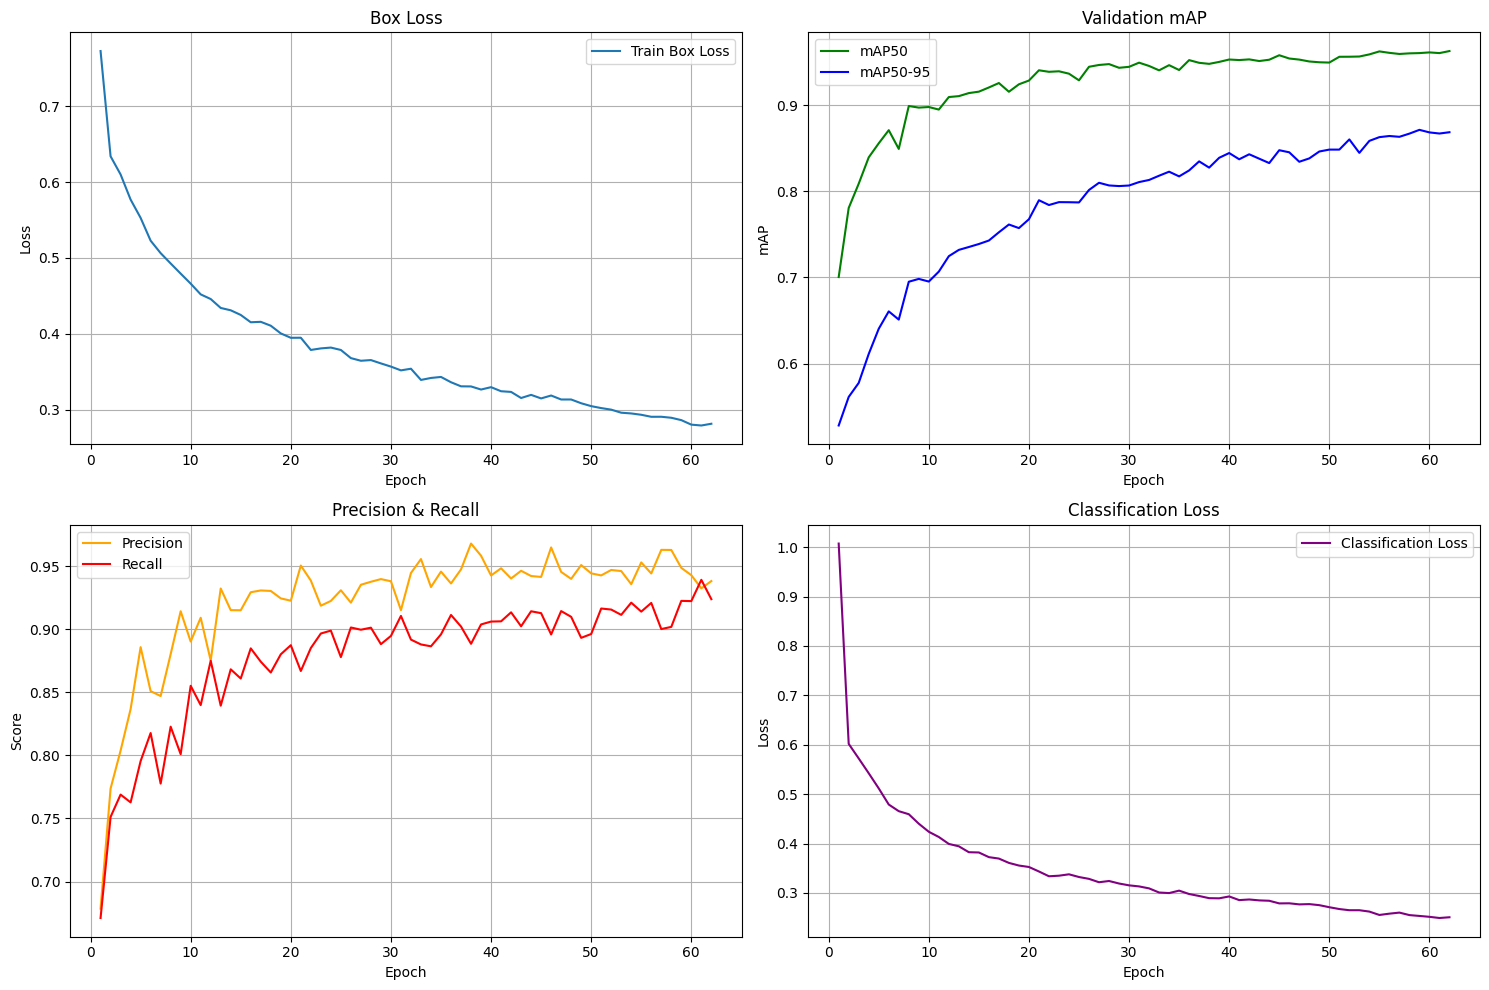

Saved training_results.png


In [17]:
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

results_dir = 'runs/detect/retail_yolov8s_combined'

results_df = pd.read_csv(f'{results_dir}/results.csv')
results_df.columns = results_df.columns.str.strip()

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

axes[0, 0].plot(results_df['epoch'], results_df['train/box_loss'], label='Train Box Loss')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].set_title('Box Loss')
axes[0, 0].legend()
axes[0, 0].grid(True)

axes[0, 1].plot(results_df['epoch'], results_df['metrics/mAP50(B)'], label='mAP50', color='green')
axes[0, 1].plot(results_df['epoch'], results_df['metrics/mAP50-95(B)'], label='mAP50-95', color='blue')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('mAP')
axes[0, 1].set_title('Validation mAP')
axes[0, 1].legend()
axes[0, 1].grid(True)

axes[1, 0].plot(results_df['epoch'], results_df['metrics/precision(B)'], label='Precision', color='orange')
axes[1, 0].plot(results_df['epoch'], results_df['metrics/recall(B)'], label='Recall', color='red')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Score')
axes[1, 0].set_title('Precision & Recall')
axes[1, 0].legend()
axes[1, 0].grid(True)

axes[1, 1].plot(results_df['epoch'], results_df['train/cls_loss'], label='Classification Loss', color='purple')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Loss')
axes[1, 1].set_title('Classification Loss')
axes[1, 1].legend()
axes[1, 1].grid(True)

plt.tight_layout()
plt.savefig('training_results.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved training_results.png")

### Sample Detection Results
Displaying sample frames with all 4 classes detected

Sample detections for each class:



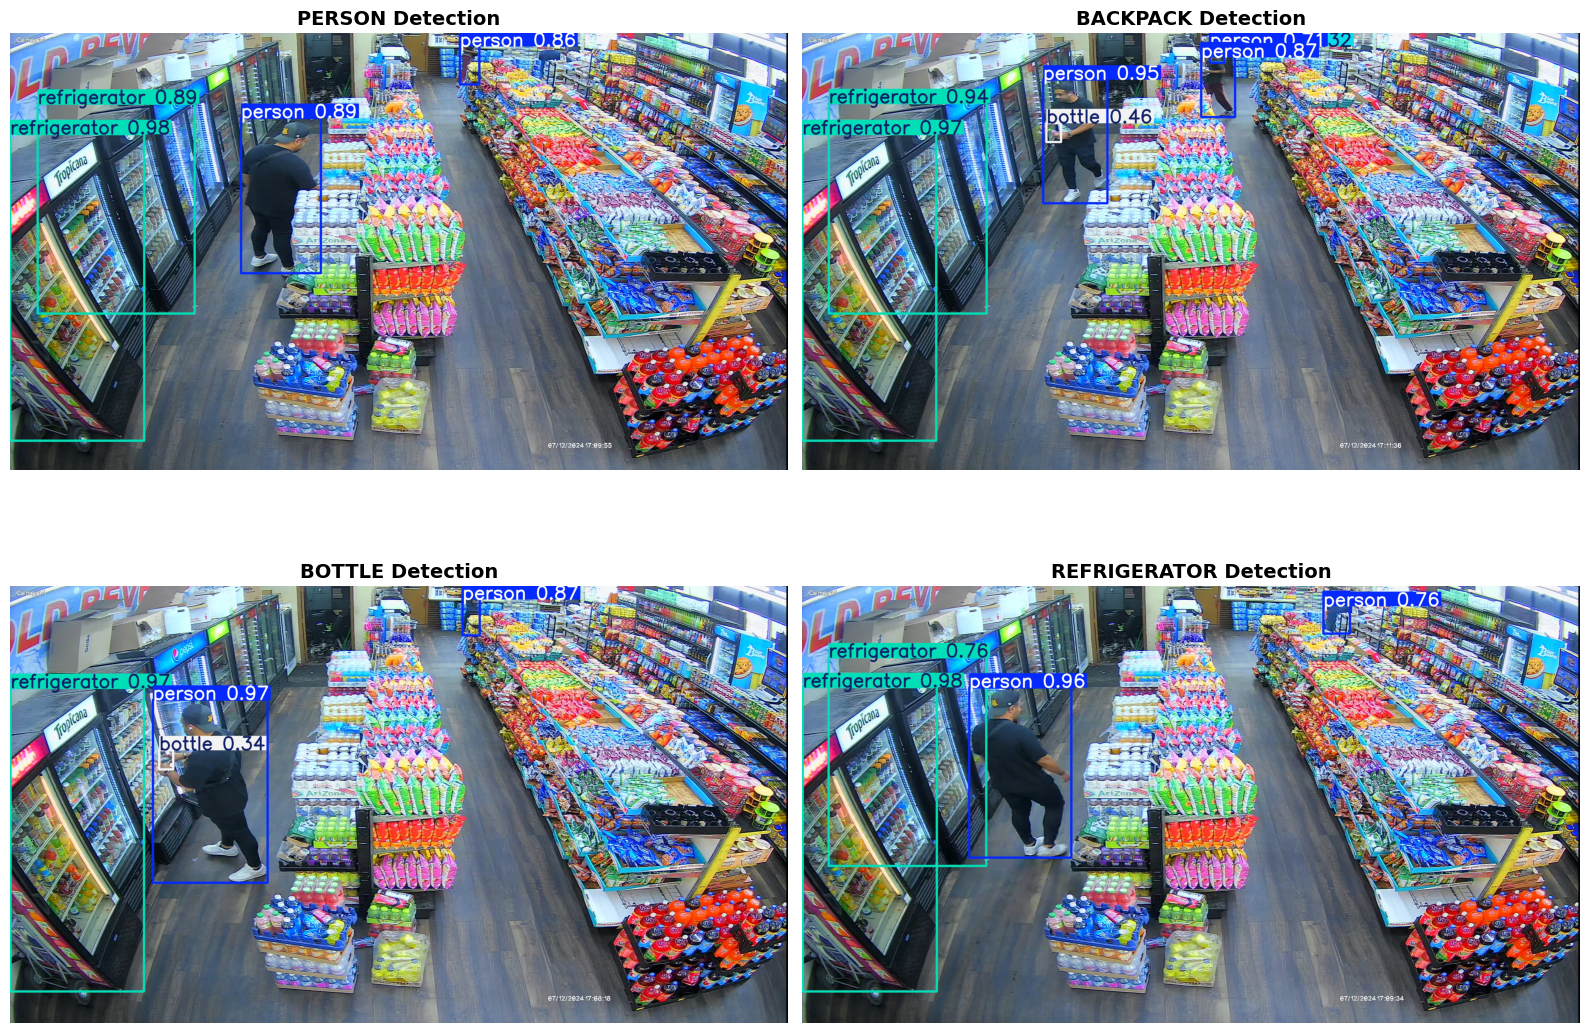

Saved sample_detections.png


In [20]:
import glob
import random

mp4_batches = ['inference_outputs/mp4_batch1', 'inference_outputs/mp4_batch2', 
               'inference_outputs/mp4_batch3', 'inference_outputs/mp4_batch4']

frames_per_class = {0: [], 1: [], 2: [], 3: []}
class_names_display = ['person', 'backpack', 'bottle', 'refrigerator']

for batch_dir in mp4_batches:
    if not os.path.exists(batch_dir):
        continue
    
    for img_path in sorted(glob.glob(f'{batch_dir}/*.jpg')):
        label_path = img_path.replace(batch_dir, f'{batch_dir}/labels').replace('.jpg', '.txt')
        
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                for line in f:
                    if line.strip():
                        class_id = int(line.split()[0])
                        frames_per_class[class_id].append(img_path)

selected_frames = []
for class_id in range(4):
    if frames_per_class[class_id]:
        selected_frames.append(random.choice(frames_per_class[class_id]))
    else:
        selected_frames.append(None)

print("Sample detections for each class:\n")

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for i, (class_id, frame_path) in enumerate(zip(range(4), selected_frames)):
    if frame_path:
        img = cv2.imread(frame_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        axes[i].imshow(img_rgb)
        axes[i].axis('off')
        axes[i].set_title(f'{class_names_display[class_id].upper()} Detection', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('sample_detections.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved sample_detections.png")

In [21]:
import shutil
import os

download_dir = 'github_deliverables'
os.makedirs(download_dir, exist_ok=True)

print("Preparing files for GitHub...\n")

# 1. Model weights and checkpoints
print("1. Copying model weights...")
os.makedirs(f'{download_dir}/weights', exist_ok=True)
shutil.copy('runs/detect/retail_yolov8s_combined/weights/best.pt', f'{download_dir}/weights/best.pt')
shutil.copy('runs/detect/retail_yolov8s_combined/weights/last.pt', f'{download_dir}/weights/last.pt')
print("   ✓ Copied best.pt and last.pt")

# 2. Requirements.txt
print("\n2. Copying requirements.txt...")
shutil.copy('requirements.txt', f'{download_dir}/requirements.txt')
print("   ✓ Copied requirements.txt")

# 3. Datasets
print("\n3. Copying datasets...")
shutil.copytree('YOLO-Object-Detection-1', f'{download_dir}/YOLO-Object-Detection-1', dirs_exist_ok=True)
print("   ✓ Copied original dataset")

shutil.copytree('YOLO-Combined', f'{download_dir}/YOLO-Combined', dirs_exist_ok=True)
print("   ✓ Copied combined dataset")

# 4. Output videos
print("\n4. Copying output videos...")
os.makedirs(f'{download_dir}/inference_outputs', exist_ok=True)

if os.path.exists('inference_outputs/mov_detections'):
    mov_video = [f for f in os.listdir('inference_outputs/mov_detections') if f.endswith('.avi')]
    if mov_video:
        shutil.copy(f'inference_outputs/mov_detections/{mov_video[0]}', 
                    f'{download_dir}/inference_outputs/mov_annotated.avi')
        print("   ✓ Copied MOV output")

if os.path.exists('final_mp4_annotated.mp4'):
    shutil.copy('final_mp4_annotated.mp4', f'{download_dir}/inference_outputs/mp4_annotated.mp4')
    print("   ✓ Copied MP4 output")


print(f"\n{'='*50}")
print("All files ready in: {download_dir}/")
print("Now compress and download:")
print(f"Run: !tar -czf deliverables.tar.gz {download_dir}")
print("="*50)

Preparing files for GitHub...

1. Copying model weights...
   ✓ Copied best.pt and last.pt

2. Copying requirements.txt...
   ✓ Copied requirements.txt

3. Copying datasets...
   ✓ Copied original dataset
   ✓ Copied combined dataset

4. Copying output videos...
   ✓ Copied MOV output
   ✓ Copied MP4 output

All files ready in: {download_dir}/
Now compress and download:
Run: !tar -czf deliverables.tar.gz github_deliverables


In [22]:
!tar -czf deliverables.tar.gz github_deliverables